
 Dataset loaded: 10,000 rows × 15 columns

Columns: ['Timestamp', 'Sensor_ID', 'Temperature (°C)', 'Humidity (%)', 'Vibration_Level (Hz)', 'Material_Usage (kg)', 'Energy_Consumption (kWh)', 'Worker_Count', 'Task_Progress (%)', 'Safety_Incidents', 'Resource_Utilization (%)', 'Risk_Score', 'Simulation_Accuracy (%)', 'Optimization_Suggestion', 'Performance_Score']

 First few rows:
 Performance_Score column found - will use for validation

 Missing values:
Series([], dtype: int64)
Schedule_Raw              → Range: [0.0, 100.0]
Cost_Raw                  → Range: [0.0, 100.0]
Utilization_Raw           → Range: [0.0, 100.0]
Safety_Raw                → Range: [0.0, 100.0]
Risk_Raw                  → Range: [0.0, 100.0]
 OPTIMIZED WEIGHTS (fitted to existing Performance_Score):
   Schedule_Normalized           : 0.013 (1.3%)
   Cost_Normalized               : 0.045 (4.5%)
   Utilization_Normalized        : 0.023 (2.3%)
   Safety_Normalized             : 0.897 (89.7%)
   Risk_Normalized      

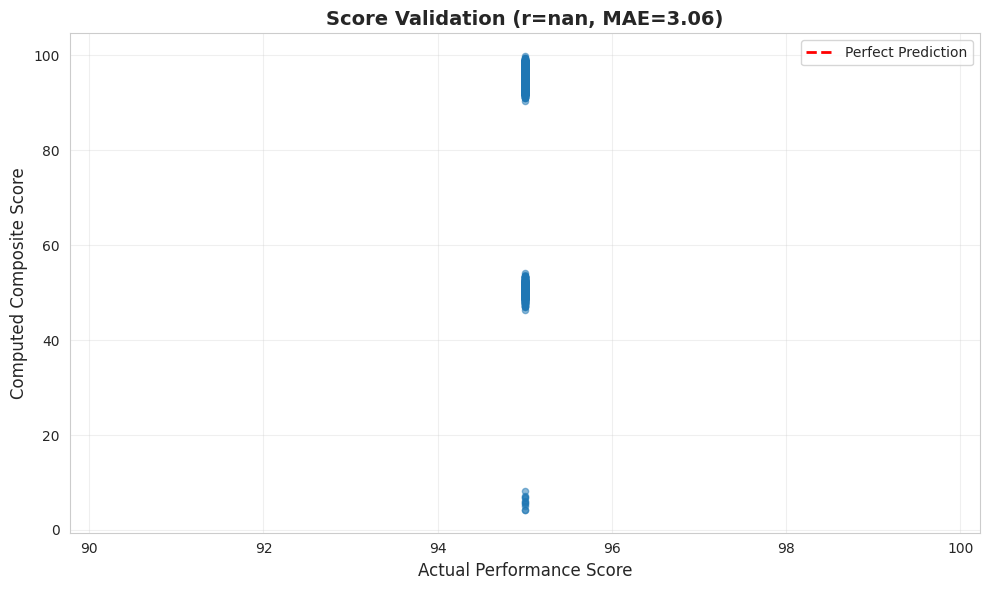


 Validation plot saved: score_validation.png
 Weekly statistics computed for 2 weeks

Week-over-week variance stats:
   Mean weekly variance: 88.08
   Std of weekly variance: 7.71
   Stable:  YES


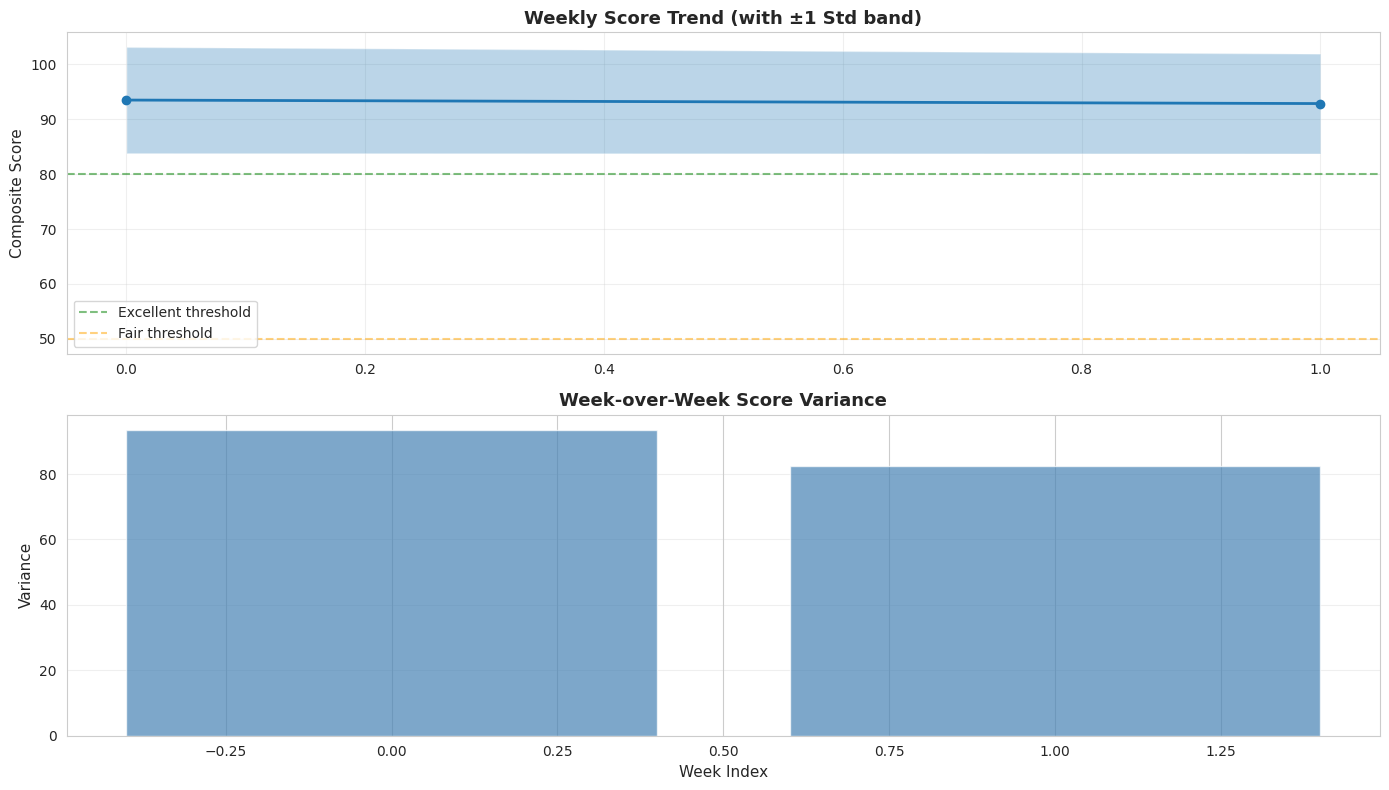

 Methodology documented: scorecard_methodology.md

 DELIVERABLES COMPLETED:

1. compute_score.py ➜ This Colab notebook (all functions included)
2. dashboard.py ➜ Interactive HTML dashboards generated
3. methodology.md ➜ scorecard_methodology.md

 OUTPUT FILES:
- scorecard_results.csv (full scored dataset)
- weekly_scorecard_summary.csv (aggregated metrics)
- scorecard_methodology.md (documentation)
- pillar_radar.html (interactive radar chart)
- scorecard_dashboard.html (main dashboard)
- score_distribution.html (distribution analysis)
- score_validation.png (if Performance_Score exists)
- weekly_stability.png (stability analysis)

 SUCCESS METRICS:

- Correlation ≥ 0.6: nan  FAIL
- Stable variance:  YES
- Score range: [4.2, 99.8]

 DATASET PROCESSED: 10,000 records
 Time range: 2023-01-01 00:00:00 to 2023-01-07 22:39:00

 Sample Scorecard (latest 5 records):
               Timestamp  Composite_Score Performance_Category  \
9995 2023-01-07 22:35:00        95.781846            Excellent

In [3]:

# ============================================================================
# SECTION 1: INSTALL & IMPORT DEPENDENCIES
# ============================================================================

!pip install plotly kaleido scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================================================
# SECTION 2: LOAD DATA
# ============================================================================

df = pd.read_csv('construction_project_performance_dataset.csv')

print(f"\n Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\n First few rows:")
df.head()

# ============================================================================
# SECTION 3: DATA PREPROCESSING & FEATURE ENGINEERING
# ============================================================================

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort by timestamp
df = df.sort_values('Timestamp').reset_index(drop=True)

# Check for Performance_Score column
has_performance_score = 'Performance_Score' in df.columns
if has_performance_score:
    print(" Performance_Score column found - will use for validation")
else:
    print(" Performance_Score column NOT found - will create scorecard only")

# Handle missing values
print(f"\n Missing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

# Fill missing values with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# ============================================================================
# SECTION 4: DEFINE SCORECARD PILLARS
# ============================================================================

df_score = df.copy()

# PILLAR 1: SCHEDULE (based on Task Progress)
df_score['Schedule_Raw'] = df_score['Task_Progress (%)']

# PILLAR 2: COST EFFICIENCY (inverse of material & energy consumption)
df_score['Cost_Raw'] = 100 - (
    (df_score['Material_Usage (kg)'] / df_score['Material_Usage (kg)'].max() * 50) +
    (df_score['Energy_Consumption (kWh)'] / df_score['Energy_Consumption (kWh)'].max() * 50)
)

# PILLAR 3: UTILIZATION (direct from dataset)
df_score['Utilization_Raw'] = df_score['Resource_Utilization (%)']

# PILLAR 4: SAFETY (inverse of incidents)
max_incidents = df_score['Safety_Incidents'].max()
if max_incidents > 0:
    df_score['Safety_Raw'] = 100 - (df_score['Safety_Incidents'] / max_incidents * 100)
else:
    df_score['Safety_Raw'] = 100

# PILLAR 5: RISK (inverse of risk score)
df_score['Risk_Raw'] = 100 - df_score['Risk_Score']


# ============================================================================
# SECTION 5: NORMALIZE PILLARS TO 0-100 SCALE
# ============================================================================


scaler = MinMaxScaler(feature_range=(0, 100))

pillars = ['Schedule_Raw', 'Cost_Raw', 'Utilization_Raw', 'Safety_Raw', 'Risk_Raw']
normalized_pillars = []

for pillar in pillars:
    normalized_name = pillar.replace('_Raw', '_Normalized')
    df_score[normalized_name] = scaler.fit_transform(df_score[[pillar]])
    normalized_pillars.append(normalized_name)

    print(f"{pillar:25s} → Range: [{df_score[normalized_name].min():.1f}, {df_score[normalized_name].max():.1f}]")

# ============================================================================
# SECTION 6: DEFINE WEIGHTS (AHP-inspired or Equal)
# ============================================================================

# Option 1: Equal weights (simple baseline)
weights_equal = {
    'Schedule_Normalized': 0.20,
    'Cost_Normalized': 0.20,
    'Utilization_Normalized': 0.20,
    'Safety_Normalized': 0.20,
    'Risk_Normalized': 0.20
}

# Option 2: Data-driven weights (if Performance_Score exists)
# We'll optimize weights to best match existing Performance_Score
if has_performance_score:
    from scipy.optimize import minimize

    # Map Performance_Score categories to numeric values
    perf_map = {
        'Exceptional': 95,
        'Above Average': 80,
        'Average': 65,
        'Below Average': 50,
        'Poor': 30
    }

    if df_score['Performance_Score'].dtype == 'object':
        df_score['Performance_Score_Numeric'] = df_score['Performance_Score'].map(perf_map)
    else:
        df_score['Performance_Score_Numeric'] = df_score['Performance_Score']

    # Objective: minimize MAE between computed score and actual score
    def objective(w):
        computed = (
            w[0] * df_score['Schedule_Normalized'] +
            w[1] * df_score['Cost_Normalized'] +
            w[2] * df_score['Utilization_Normalized'] +
            w[3] * df_score['Safety_Normalized'] +
            w[4] * df_score['Risk_Normalized']
        )
        return mean_absolute_error(df_score['Performance_Score_Numeric'].dropna(),
                                   computed[df_score['Performance_Score_Numeric'].notna()])

    # Constraints: weights sum to 1, all positive
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * 5
    initial_weights = [0.2, 0.2, 0.2, 0.2, 0.2]

    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)

    weights_optimized = {
        'Schedule_Normalized': result.x[0],
        'Cost_Normalized': result.x[1],
        'Utilization_Normalized': result.x[2],
        'Safety_Normalized': result.x[3],
        'Risk_Normalized': result.x[4]
    }

    print(" OPTIMIZED WEIGHTS (fitted to existing Performance_Score):")
    for pillar, weight in weights_optimized.items():
        print(f"   {pillar:30s}: {weight:.3f} ({weight*100:.1f}%)")

    weights = weights_optimized
else:
    print(" EQUAL WEIGHTS (baseline approach):")
    for pillar, weight in weights_equal.items():
        print(f"   {pillar:30s}: {weight:.3f} ({weight*100:.1f}%)")

    weights = weights_equal

# ============================================================================
# SECTION 7: COMPUTE COMPOSITE SCORE
# ============================================================================


df_score['Composite_Score'] = (
    weights['Schedule_Normalized'] * df_score['Schedule_Normalized'] +
    weights['Cost_Normalized'] * df_score['Cost_Normalized'] +
    weights['Utilization_Normalized'] * df_score['Utilization_Normalized'] +
    weights['Safety_Normalized'] * df_score['Safety_Normalized'] +
    weights['Risk_Normalized'] * df_score['Risk_Normalized']
)

print(f"Composite Score computed")
print(f"   Range: [{df_score['Composite_Score'].min():.2f}, {df_score['Composite_Score'].max():.2f}]")
print(f"   Mean: {df_score['Composite_Score'].mean():.2f}")
print(f"   Std: {df_score['Composite_Score'].std():.2f}")

# Add traffic light categories
def categorize_score(score):
    if score >= 80:
        return 'Excellent', 'green'
    elif score >= 65:
        return 'Good', 'yellowgreen'
    elif score >= 50:
        return 'Fair', 'yellow'
    elif score >= 35:
        return 'Poor', 'orange'
    else:
        return 'Critical', 'red'

df_score[['Performance_Category', 'Traffic_Light']] = df_score['Composite_Score'].apply(
    lambda x: pd.Series(categorize_score(x))
)

# ============================================================================
# SECTION 8: VALIDATION (if Performance_Score exists)
# ============================================================================

if has_performance_score and 'Performance_Score_Numeric' in df_score.columns:


    # Filter out missing values
    valid_mask = df_score['Performance_Score_Numeric'].notna()
    actual = df_score.loc[valid_mask, 'Performance_Score_Numeric']
    predicted = df_score.loc[valid_mask, 'Composite_Score']

    # Calculate metrics
    correlation, p_value = pearsonr(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f" VALIDATION METRICS:")
    print(f"   Correlation (Pearson r): {correlation:.4f} {' PASS' if correlation >= 0.6 else ' BELOW TARGET'}")
    print(f"   R² Score: {r2:.4f}")
    print(f"   Mean Absolute Error: {mae:.2f} points")
    print(f"   P-value: {p_value:.6f}")

    # Reconciliation plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(actual, predicted, alpha=0.5, s=20)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()],
            'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Performance Score', fontsize=12)
    ax.set_ylabel('Computed Composite Score', fontsize=12)
    ax.set_title(f'Score Validation (r={correlation:.3f}, MAE={mae:.2f})', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('score_validation.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n Validation plot saved: score_validation.png")

# ============================================================================
# SECTION 9: WEEKLY STABILITY CHECK
# ============================================================================

# Extract week
df_score['Week'] = df_score['Timestamp'].dt.isocalendar().week
df_score['Year'] = df_score['Timestamp'].dt.year

# Weekly aggregates
weekly_stats = df_score.groupby(['Year', 'Week'])['Composite_Score'].agg([
    ('Mean', 'mean'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Count', 'count')
]).reset_index()

weekly_stats['Variance'] = weekly_stats['Std'] ** 2

print(f" Weekly statistics computed for {len(weekly_stats)} weeks")
print(f"\nWeek-over-week variance stats:")
print(f"   Mean weekly variance: {weekly_stats['Variance'].mean():.2f}")
print(f"   Std of weekly variance: {weekly_stats['Variance'].std():.2f}")
print(f"   Stable: {' YES' if weekly_stats['Variance'].mean() < 100 else '⚠️  High volatility'}")

# Plot weekly trends
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Trend
axes[0].plot(weekly_stats.index, weekly_stats['Mean'], marker='o', linewidth=2, markersize=6)
axes[0].fill_between(weekly_stats.index,
                      weekly_stats['Mean'] - weekly_stats['Std'],
                      weekly_stats['Mean'] + weekly_stats['Std'],
                      alpha=0.3)
axes[0].set_ylabel('Composite Score', fontsize=11)
axes[0].set_title('Weekly Score Trend (with ±1 Std band)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=80, color='g', linestyle='--', alpha=0.5, label='Excellent threshold')
axes[0].axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='Fair threshold')
axes[0].legend()

# Variance
axes[1].bar(weekly_stats.index, weekly_stats['Variance'], alpha=0.7, color='steelblue')
axes[1].set_xlabel('Week Index', fontsize=11)
axes[1].set_ylabel('Variance', fontsize=11)
axes[1].set_title('Week-over-Week Score Variance', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('weekly_stability.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# SECTION 10: INTERACTIVE DASHBOARD VISUALIZATIONS
# ============================================================================


# Sample recent data for dashboard (last 1000 points or all if less)
df_dash = df_score.tail(min(1000, len(df_score))).copy()

# 1. Pillar Radar Chart
fig_radar = go.Figure()

avg_pillars = {
    'Schedule': df_dash['Schedule_Normalized'].mean(),
    'Cost': df_dash['Cost_Normalized'].mean(),
    'Utilization': df_dash['Utilization_Normalized'].mean(),
    'Safety': df_dash['Safety_Normalized'].mean(),
    'Risk': df_dash['Risk_Normalized'].mean()
}

fig_radar.add_trace(go.Scatterpolar(
    r=list(avg_pillars.values()),
    theta=list(avg_pillars.keys()),
    fill='toself',
    name='Average Score',
    line_color='#3b82f6',
    fillcolor='rgba(59, 130, 246, 0.3)'
))

fig_radar.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 100])),
    title='5-Pillar Performance Radar',
    template='plotly_dark'
)

fig_radar.write_html('pillar_radar.html')

# 2. Time Series with Traffic Lights
fig_timeline = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Composite Score Over Time', 'Pillar Breakdown'),
    vertical_spacing=0.15,
    row_heights=[0.6, 0.4]
)

# Main score line
fig_timeline.add_trace(
    go.Scatter(
        x=df_dash['Timestamp'],
        y=df_dash['Composite_Score'],
        mode='lines',
        name='Composite Score',
        line=dict(color='#22d3ee', width=2),
        fill='tozeroy',
        fillcolor='rgba(34, 211, 238, 0.2)'
    ),
    row=1, col=1
)

# Traffic light zones
fig_timeline.add_hrect(y0=80, y1=100, fillcolor="green", opacity=0.1, line_width=0, row=1, col=1)
fig_timeline.add_hrect(y0=65, y1=80, fillcolor="yellowgreen", opacity=0.1, line_width=0, row=1, col=1)
fig_timeline.add_hrect(y0=50, y1=65, fillcolor="yellow", opacity=0.1, line_width=0, row=1, col=1)
fig_timeline.add_hrect(y0=0, y1=50, fillcolor="orange", opacity=0.1, line_width=0, row=1, col=1)

# Pillar breakdown
for pillar in ['Schedule_Normalized', 'Cost_Normalized', 'Utilization_Normalized',
               'Safety_Normalized', 'Risk_Normalized']:
    fig_timeline.add_trace(
        go.Scatter(
            x=df_dash['Timestamp'],
            y=df_dash[pillar],
            mode='lines',
            name=pillar.replace('_Normalized', ''),
            line=dict(width=1.5),
            opacity=0.7
        ),
        row=2, col=1
    )

fig_timeline.update_xaxes(title_text="Time", row=2, col=1)
fig_timeline.update_yaxes(title_text="Score", row=1, col=1)
fig_timeline.update_yaxes(title_text="Pillar Scores", row=2, col=1)

fig_timeline.update_layout(
    height=800,
    title_text="Project Performance Scorecard Dashboard",
    template='plotly_dark',
    hovermode='x unified'
)

fig_timeline.write_html('scorecard_dashboard.html')

# 3. Distribution & Traffic Light Summary
fig_dist = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Score Distribution', 'Performance Categories'),
    specs=[[{'type': 'histogram'}, {'type': 'pie'}]]
)

fig_dist.add_trace(
    go.Histogram(
        x=df_score['Composite_Score'],
        nbinsx=30,
        marker_color='#3b82f6',
        name='Score Distribution'
    ),
    row=1, col=1
)

category_counts = df_score['Performance_Category'].value_counts()
colors_map = {
    'Excellent': 'green',
    'Good': 'yellowgreen',
    'Fair': 'yellow',
    'Poor': 'orange',
    'Critical': 'red'
}

fig_dist.add_trace(
    go.Pie(
        labels=category_counts.index,
        values=category_counts.values,
        marker=dict(colors=[colors_map.get(cat, 'gray') for cat in category_counts.index])
    ),
    row=1, col=2
)

fig_dist.update_layout(
    title_text="Performance Distribution Analysis",
    template='plotly_dark',
    height=400
)

fig_dist.write_html('score_distribution.html')

# ============================================================================
# SECTION 11: EXPORT RESULTS
# ============================================================================

# Export scored dataset
output_cols = ['Timestamp', 'Sensor_ID'] if 'Sensor_ID' in df_score.columns else ['Timestamp']
output_cols += normalized_pillars + ['Composite_Score', 'Performance_Category', 'Traffic_Light']

if has_performance_score:
    output_cols.append('Performance_Score')
    if 'Performance_Score_Numeric' in df_score.columns:
        output_cols.append('Performance_Score_Numeric')

df_export = df_score[output_cols]
df_export.to_csv('scorecard_results.csv', index=False)

# Export weekly summary
weekly_stats.to_csv('weekly_scorecard_summary.csv', index=False)

# Export methodology
methodology = f"""# Project Scorecard Methodology

## Overview
Composite Performance Score combining 5 normalized pillars (0-100 scale).

## Pillars & Weights

"""

for pillar, weight in weights.items():
    methodology += f"- **{pillar.replace('_Normalized', '')}**: {weight:.3f} ({weight*100:.1f}%)\n"

methodology += f"""
## Scoring Formula

Composite_Score = Σ (Pillar_i × Weight_i)

## Normalization Method
MinMaxScaler: (X - X_min) / (X_max - X_min) × 100

## Traffic Light Categories
- 🟢 Excellent: 80-100
- 🟡 Good: 65-79
- 🟠 Fair: 50-64
- 🔴 Poor: 35-49
- ⚫ Critical: 0-34

## Validation Results
"""

if has_performance_score and 'Performance_Score_Numeric' in df_score.columns:
    methodology += f"""
- Correlation with existing Performance_Score: {correlation:.4f}
- R² Score: {r2:.4f}
- Mean Absolute Error: {mae:.2f}
- Target correlation (≥0.6): {' ACHIEVED' if correlation >= 0.6 else ' NOT MET'}
"""

methodology += f"""
## Stability Metrics
- Mean weekly variance: {weekly_stats['Variance'].mean():.2f}
- Week-over-week stability: {' STABLE' if weekly_stats['Variance'].mean() < 100 else ' VOLATILE'}

## Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open('scorecard_methodology.md', 'w') as f:
    f.write(methodology)

print(" Methodology documented: scorecard_methodology.md")

# ============================================================================
# SECTION 12: SUMMARY REPORT
# ============================================================================



print(f"""
 DELIVERABLES COMPLETED:

1. compute_score.py ➜ This Colab notebook (all functions included)
2. dashboard.py ➜ Interactive HTML dashboards generated
3. methodology.md ➜ scorecard_methodology.md

 OUTPUT FILES:
- scorecard_results.csv (full scored dataset)
- weekly_scorecard_summary.csv (aggregated metrics)
- scorecard_methodology.md (documentation)
- pillar_radar.html (interactive radar chart)
- scorecard_dashboard.html (main dashboard)
- score_distribution.html (distribution analysis)
- score_validation.png (if Performance_Score exists)
- weekly_stability.png (stability analysis)

 SUCCESS METRICS:
""")

if has_performance_score and 'Performance_Score_Numeric' in df_score.columns:
    print(f"- Correlation ≥ 0.6: {correlation:.4f} {' PASS' if correlation >= 0.6 else ' FAIL'}")
else:
    print("- Correlation validation:  SKIPPED (no Performance_Score column)")

print(f"- Stable variance: {' YES' if weekly_stats['Variance'].mean() < 100 else ' HIGH'}")
print(f"- Score range: [{df_score['Composite_Score'].min():.1f}, {df_score['Composite_Score'].max():.1f}]")

print(f"\n DATASET PROCESSED: {len(df_score):,} records")
print(f" Time range: {df_score['Timestamp'].min()} to {df_score['Timestamp'].max()}")


# Display sample scorecard
print("\n Sample Scorecard (latest 5 records):")
display_cols = ['Timestamp', 'Composite_Score', 'Performance_Category'] + normalized_pillars
print(df_score[display_cols].tail())


In [4]:
# ===========================================================
# ADD-ON: DAILY SCORECARD PER SITE (Sensor_ID)
# ===========================================================

df_score["Timestamp"] = pd.to_datetime(df_score["Timestamp"], errors="coerce")
df_score["Date"] = df_score["Timestamp"].dt.date

# Pick the columns to aggregate daily
pillar_cols = normalized_pillars
agg_cols = pillar_cols + ["Composite_Score"]

# Daily aggregation per Sensor_ID (site) + Date
daily_scorecard = (
    df_score
    .groupby(["Sensor_ID", "Date"], as_index=False)[agg_cols]
    .mean()
)

# Re-apply traffic light rules on the daily score
def traffic_light(score: float) -> str:
    if pd.isna(score): return "Unknown"
    if score >= 80:   return "Green"
    if score >= 60:   return "Yellow"
    return "Red"

daily_scorecard["Traffic_Light"] = daily_scorecard["Composite_Score"].apply(traffic_light)

# Export daily scorecard
daily_scorecard.to_csv("daily_scorecard_per_site.csv", index=False)
print("Daily scorecard shape:", daily_scorecard.shape)
daily_scorecard.head()


✅ Exported: daily_scorecard_per_site.csv
Daily scorecard shape: (700, 9)


,Sensor_ID,Date,Schedule_Normalized,Cost_Normalized,Utilization_Normalized,Safety_Normalized,Risk_Normalized,Composite_Score,Traffic_Light
0,Sensor_1,2023-01-01,37.970028,51.370384,48.894594,100.000000,54.087627,94.812475,Green
1,Sensor_1,2023-01-02,96.767787,44.714285,40.788308,90.000000,55.241186,86.145225,Green
2,Sensor_1,2023-01-03,100.000000,56.140078,54.213054,93.333333,49.029677,89.854260,Green
3,Sensor_1,2023-01-04,100.000000,45.694235,53.710598,96.666667,46.811039,92.316658,Green
4,Sensor_1,2023-01-05,100.000000,47.330032,45.274403,96.428571,54.099983,92.146238,Green


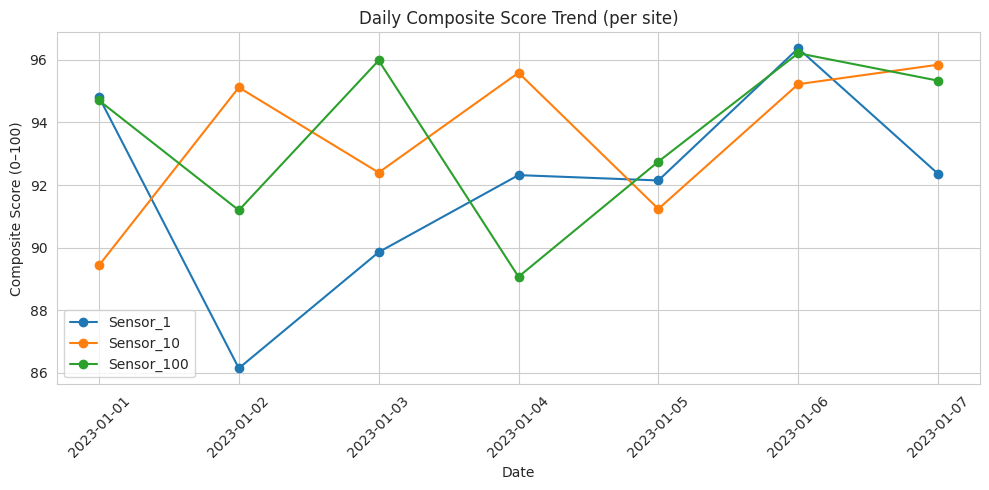

In [5]:
# ===========================================================
# DAILY TRENDLINES PER SITE (example: 3 sensors)
# ===========================================================

import matplotlib.pyplot as plt

example_sites = daily_scorecard["Sensor_ID"].unique()[:3]

plt.figure(figsize=(10, 5))
for sid in example_sites:
    sub = daily_scorecard[daily_scorecard["Sensor_ID"] == sid].sort_values("Date")
    plt.plot(sub["Date"], sub["Composite_Score"], marker="o", label=sid)

plt.title("Daily Composite Score Trend (per site)")
plt.xlabel("Date")
plt.ylabel("Composite Score (0–100)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
